In [1]:
%load_ext edx_jupyter
%load_ext autoreload
%autoreload 2

In [2]:
%vertica SELECT 'Connected to Vertica'

password: ········


,?column?
0,Connected to Vertica


In [3]:
%matplotlib inline

In [4]:
import datetime

test_end_date = datetime.date(2017, 6, 20)
test_start_date = test_end_date - datetime.timedelta(days=13)
sample_start_date = test_start_date
sample_end_date = sample_start_date + datetime.timedelta(days=6)
print(f'We would start accruing enrollments at {sample_start_date} 00:00:00 UTC and end at {sample_end_date} 23:59:59 UTC'
      f' when the first email would be sent. We would look at activity starting {test_start_date} 00:00:00 UTC and'
      f' ending at {test_end_date} 23:59:59 UTC.')

We would start accruing enrollments at 2017-06-07 00:00:00 UTC and end at 2017-06-13 23:59:59 UTC when the first email would be sent. We would look at activity starting 2017-06-07 00:00:00 UTC and ending at 2017-06-20 23:59:59 UTC.


In [5]:
%%vertica
SET TIME ZONE TO UTC

,?column?


In [6]:
%%vertica (sample_start_date=sample_start_date, sample_end_date=sample_end_date, test_start_date=test_start_date)
DROP TABLE IF EXISTS ex_enrollments;
CREATE LOCAL TEMPORARY TABLE ex_enrollments
ON COMMIT PRESERVE ROWS AS
SELECT
    uc.user_id,
    uc.course_id
FROM
    production.d_user_course uc
JOIN business_intelligence.course_master c
    ON c.course_id = uc.course_id AND c.pacing_type = 'self_paced' AND c.course_start_date <= :test_start_date
WHERE
    uc.first_enrollment_time::DATE BETWEEN :sample_start_date AND :sample_end_date

,?column?


In [7]:
%%vertica (test_start_date=test_start_date, test_end_date=test_end_date) -> engagement
SELECT
    e.user_id,
    e.course_id,
    SUM(COALESCE(act.cnt_engaged_activity, 0)) AS cnt_engaged_activity
FROM
    ex_enrollments e
LEFT JOIN business_intelligence.activity_engagement_user_daily act
    ON e.course_id = act.course_id AND e.user_id = act.user_id AND act.date BETWEEN :test_start_date AND :test_end_date
GROUP BY 1, 2

In [8]:
len(engagement)

133887

/usr/local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


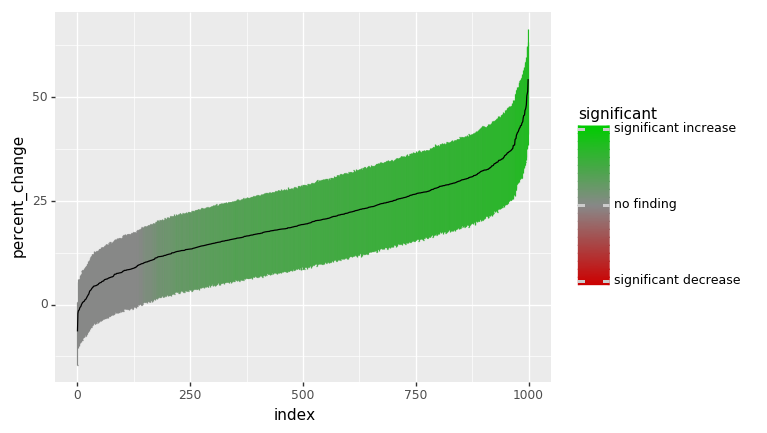

<ggplot: (-9223363265071818303)>

Effective power: 0.863
% of Confidence Intervals that contain the true effect size: 0.706


In [9]:
import edx_stats
import edx_plot
from plotnine import *

effect_size = 0.2

results = edx_stats.estimate_power(
    baseline=engagement.cnt_engaged_activity,
    lift=effect_size,
    treatment_size=3500,
    pwr_iterations=1000,
    bs_iterations=10000,
    discrete=False,
)

display(
    ggplot(
        results,
        aes(x='index',
            y='percent_change',
            ymin='lower_bound',
            ymax='upper_bound',
            color='significant',
            label_size=0.5
        )
    )
    + edx_plot.geom_power()
)

print("Effective power: {}".format(len(results[results.lower_bound > 0]) / len(results)))
print("% of Confidence Intervals that contain the true effect size: {}".format(
    len(results[(results.lower_bound < (effect_size*100)) & (results.upper_bound > (effect_size*100))]) / len(results))
)

In [10]:
%%vertica (test_start_date=test_start_date, test_end_date=test_end_date) -> conversion
SELECT
    e.user_id,
    e.course_id,
    CASE
        WHEN duc.first_verified_enrollment_time IS NOT NULL
        THEN TRUE
        ELSE FALSE
    END AS converted,
    CASE
        WHEN duc.first_verified_enrollment_time IS NOT NULL
        THEN COALESCE(cm.course_seat_price, 0)
        ELSE 0
    END AS bookings
FROM
    ex_enrollments e
JOIN business_intelligence.course_master cm
    ON e.course_id = cm.course_id
LEFT JOIN production.d_user_course duc
    ON  e.course_id = duc.course_id
    AND e.user_id = duc.user_id
    AND duc.first_verified_enrollment_time BETWEEN :test_start_date AND :test_end_date

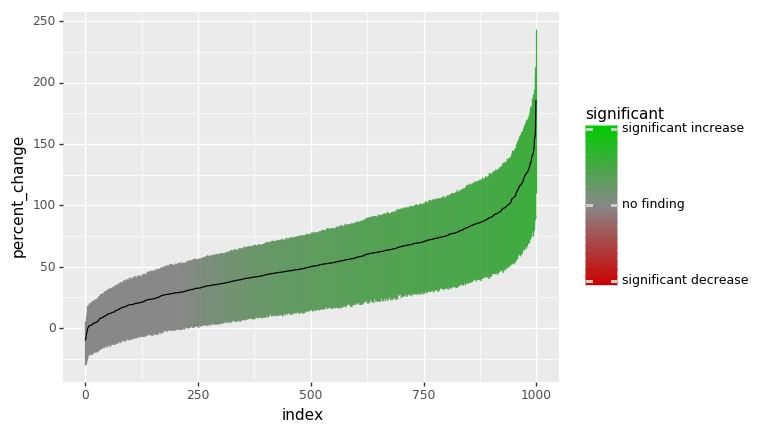

<ggplot: (8771782740684)>

Effective power: 0.781
% of Confidence Intervals that contain the true effect size: 0.761


In [11]:
import edx_stats
import edx_plot
from plotnine import *

effect_size=0.5

results = edx_stats.estimate_power(
    baseline=conversion.converted,
    lift=effect_size,
    treatment_size=3500,
    pwr_iterations=1000,
    bs_iterations=10000,
    discrete=True,
)

display(
    ggplot(
        results,
        aes(x='index',
            y='percent_change',
            ymin='lower_bound',
            ymax='upper_bound',
            color='significant',
            label_size=0.5
        )
    )
    + edx_plot.geom_power()
)

print("Effective power: {}".format(len(results[results.lower_bound > 0]) / len(results)))
print("% of Confidence Intervals that contain the true effect size: {}".format(
    len(results[(results.lower_bound < (effect_size*100)) & (results.upper_bound > (effect_size*100))]) / len(results))
)

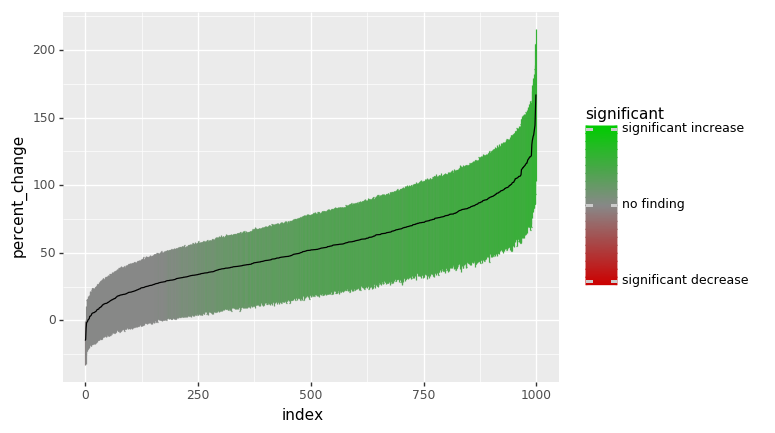

<ggplot: (8771782902648)>

Effective power: 0.84
% of Confidence Intervals that contain the true effect size: 0.746


In [12]:
import edx_stats
import edx_plot
from plotnine import *

effect_size=0.5

results = edx_stats.estimate_power(
    baseline=conversion.bookings,
    lift=effect_size,
    treatment_size=5000,
    pwr_iterations=1000,
    bs_iterations=10000,
    discrete=True
)

display(
    ggplot(
        results,
        aes(x='index',
            y='percent_change',
            ymin='lower_bound',
            ymax='upper_bound',
            color='significant',
            label_size=0.5
        )
    )
    + edx_plot.geom_power()
)

print("Effective power: {}".format(len(results[results.lower_bound > 0]) / len(results)))
print("% of Confidence Intervals that contain the true effect size: {}".format(
    len(results[(results.lower_bound < (effect_size*100)) & (results.upper_bound > (effect_size*100))]) / len(results))
)

/workspace/src/bootstrapped/bootstrapped/compare_functions.py:33: RuntimeWarning: divide by zero encountered in true_divide
  return (test_stat - ctrl_stat) * 100.0 / ctrl_stat
/workspace/src/bootstrapped/bootstrapped/compare_functions.py:33: RuntimeWarning: divide by zero encountered in true_divide
  return (test_stat - ctrl_stat) * 100.0 / ctrl_stat
/workspace/src/bootstrapped/bootstrapped/compare_functions.py:33: RuntimeWarning: divide by zero encountered in true_divide
  return (test_stat - ctrl_stat) * 100.0 / ctrl_stat
/workspace/src/bootstrapped/bootstrapped/compare_functions.py:33: RuntimeWarning: divide by zero encountered in true_divide
  return (test_stat - ctrl_stat) * 100.0 / ctrl_stat
/workspace/src/bootstrapped/bootstrapped/compare_functions.py:33: RuntimeWarning: divide by zero encountered in true_divide
  return (test_stat - ctrl_stat) * 100.0 / ctrl_stat
/workspace/src/bootstrapped/bootstrapped/compare_functions.py:33: RuntimeWarning: divide by zero encountered in tru

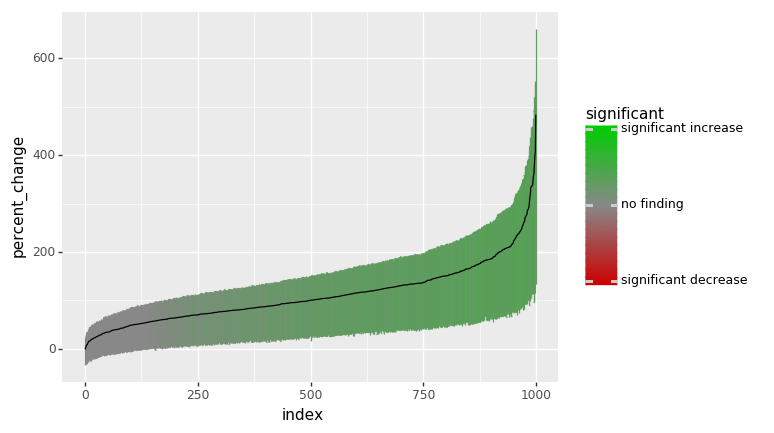

<ggplot: (-9223363265082412372)>

Effective power: 0.86
% of Confidence Intervals that contain the true effect size: 0.81


In [19]:
import edx_stats
import edx_plot
from plotnine import *

effect_size=1.0

results = edx_stats.estimate_power(
    baseline=conversion.converted,
    lift=effect_size,
    treatment_size=1800,
    pwr_iterations=1000,
    bs_iterations=10000,
    discrete=True,
)

display(
    ggplot(
        results,
        aes(x='index',
            y='percent_change',
            ymin='lower_bound',
            ymax='upper_bound',
            color='significant',
            label_size=0.5
        )
    )
    + edx_plot.geom_power()
)

print("Effective power: {}".format(len(results[results.lower_bound > 0]) / len(results)))
print("% of Confidence Intervals that contain the true effect size: {}".format(
    len(results[(results.lower_bound < (effect_size*100)) & (results.upper_bound > (effect_size*100))]) / len(results))
)

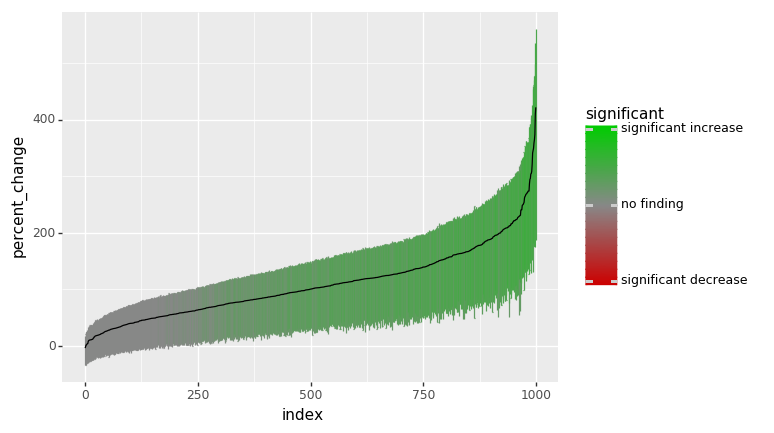

<ggplot: (-9223363265083626338)>

Effective power: 0.824
% of Confidence Intervals that contain the true effect size: 0.718


In [20]:
import edx_stats
import edx_plot
from plotnine import *

effect_size=1.0

results = edx_stats.estimate_power(
    baseline=conversion.bookings,
    lift=effect_size,
    treatment_size=2200,
    pwr_iterations=1000,
    bs_iterations=10000,
    discrete=True
)

display(
    ggplot(
        results,
        aes(x='index',
            y='percent_change',
            ymin='lower_bound',
            ymax='upper_bound',
            color='significant',
            label_size=0.5
        )
    )
    + edx_plot.geom_power()
)

print("Effective power: {}".format(len(results[results.lower_bound > 0]) / len(results)))
print("% of Confidence Intervals that contain the true effect size: {}".format(
    len(results[(results.lower_bound < (effect_size*100)) & (results.upper_bound > (effect_size*100))]) / len(results))
)